In [48]:
import tensorflow as tf
from tensorflow.keras import layers
from einops.layers.tensorflow import Rearrange
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import re


train_dir = "C:\\Users\\shawn\\Downloads\\archive\\train"
test_dir = "C:\\Users\\shawn\\Downloads\\archive\\test"


def extract_label(filename):
    match = re.match(r'(\w+)_\d+', filename)
    if match:
        return match.group(1)
    else:
        return None

train_filenames = os.listdir(train_dir)
test_filenames = os.listdir(test_dir)


train_data = {
    'filename': train_filenames,
    'label': [extract_label(filename) for filename in train_filenames]
}
train_df = pd.DataFrame(train_data)

test_data = {
    'filename': test_filenames,
    'label': [extract_label(filename) for filename in test_filenames]
}
test_df = pd.DataFrame(test_data)


print(train_df.head())
print(test_df.head())


img_size = (224, 224)
batch_size = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_dir,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  
    classes=['apple', 'banana', 'mixed', 'orange']  
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    test_dir,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  
    classes=['apple', 'banana', 'mixed', 'orange']  
)


def create_vit_model(input_shape=(224, 224, 3), num_classes=4):
    inputs = tf.keras.Input(shape=input_shape)

  
    class PatchExtractor(layers.Layer):
        def __init__(self, **kwargs):
            super(PatchExtractor, self).__init__(**kwargs)

        def call(self, inputs, **kwargs):
            patches = tf.image.extract_patches(inputs, sizes=[1, 16, 16, 1], strides=[1, 16, 16, 1], rates=[1, 1, 1, 1], padding='VALID')[..., 0]
            return patches

   
    patches = PatchExtractor()(inputs)
    patches = Rearrange('b h w -> b (h w)')(patches)

   
    patch_embedding = layers.Dense(768)(patches)
    patch_embedding = layers.LayerNormalization(epsilon=1e-6)(patch_embedding)

    
    class MultiHeadSelfAttention(layers.Layer):
        def __init__(self, num_heads=8, key_dim=64, dropout=0.1, **kwargs):
            super(MultiHeadSelfAttention, self).__init__(**kwargs)
            self.num_heads = num_heads
            self.key_dim = key_dim
            self.dropout = dropout

        def build(self, input_shape):
            self.dense_q = layers.Dense(self.num_heads * self.key_dim, activation=None)
            self.dense_k = layers.Dense(self.num_heads * self.key_dim, activation=None)
            self.dense_v = layers.Dense(self.num_heads * self.key_dim, activation=None)
            self.dropout_layer = layers.Dropout(self.dropout)

        def call(self, inputs, **kwargs):
            q = self.dense_q(inputs)
            k = self.dense_k(inputs)
            v = self.dense_v(inputs)

           
            batch_size = tf.shape(q)[0]
            q = tf.reshape(q, [batch_size, -1, self.num_heads, self.key_dim])
            k = tf.reshape(k, [batch_size, -1, self.num_heads, self.key_dim])
            v = tf.reshape(v, [batch_size, -1, self.num_heads, self.key_dim])

            q = tf.transpose(q, perm=[0, 2, 1, 3])
            k = tf.transpose(k, perm=[0, 2, 1, 3])
            v = tf.transpose(v, perm=[0, 2, 1, 3])

            attention_scores = tf.matmul(q, k, transpose_b=True)
            attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.key_dim, dtype=tf.float32))
            attention_scores = tf.nn.softmax(attention_scores, axis=-1)
            attention_scores = self.dropout_layer(attention_scores)

            output = tf.matmul(attention_scores, v)
            output = tf.transpose(output, perm=[0, 2, 1, 3])
            output = tf.reshape(output, [batch_size, -1, self.num_heads * self.key_dim])
            return output

  
    transformer_blocks = tf.keras.Sequential([
        MultiHeadSelfAttention(),
        layers.LayerNormalization(epsilon=1e-6),
        layers.Dense(768, activation='relu'),
        layers.Dropout(0.1),
        layers.LayerNormalization(epsilon=1e-6)
    ])


    transformer_output = transformer_blocks(patch_embedding)

   
    output = layers.GlobalAveragePooling1D()(transformer_output)
    output = layers.Dense(num_classes, activation='softmax')(output)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model


vit_model = create_vit_model(input_shape=img_size + (3,), num_classes=4)


vit_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


vit_model.summary()


history = vit_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


       filename  label
0   apple_1.jpg  apple
1   apple_1.xml  apple
2  apple_10.jpg  apple
3  apple_10.xml  apple
4  apple_11.jpg  apple
       filename  label
0  apple_77.jpg  apple
1  apple_77.xml  apple
2  apple_78.jpg  apple
3  apple_78.xml  apple
4  apple_79.jpg  apple
Found 240 validated image filenames belonging to 4 classes.
Found 60 validated image filenames belonging to 4 classes.


c:\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 240 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 60 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_extractor_22              │ (None, 14, 14)         │             0 │
│ (PatchExtractor)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rearrange_18 (Rearrange)        │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 768)            │       151,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_51          │ (None, 768)            │         1,536 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, None, 768)      │     1,577,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_17     │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 4)              │         3,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733,636 (6.61 MB)

 Trainable params: 1,733,636 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

c:\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.2799 - loss: 5.0044 - val_accuracy: 0.3000 - val_loss: 2.4356
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2575 - loss: 2.2477 - val_accuracy: 0.3000 - val_loss: 1.4824
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2774 - loss: 1.5423 - val_accuracy: 0.3167 - val_loss: 1.3857
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2836 - loss: 1.4696 - val_accuracy: 0.3000 - val_loss: 1.3424
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2597 - loss: 1.3913 - val_accuracy: 0.3167 - val_loss: 1.3479
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2869 - loss: 1.4176 - val_accuracy: 0.3000 - val_loss: 1.2995
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3129 - loss: 1.2939 - val_accuracy: 0.3000 - val_loss: 1.2908
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2373 - loss: 1.3839 - val_accuracy: 0.3000 - val_loss: 1.2910
Epoch 9/10

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 469ms/step


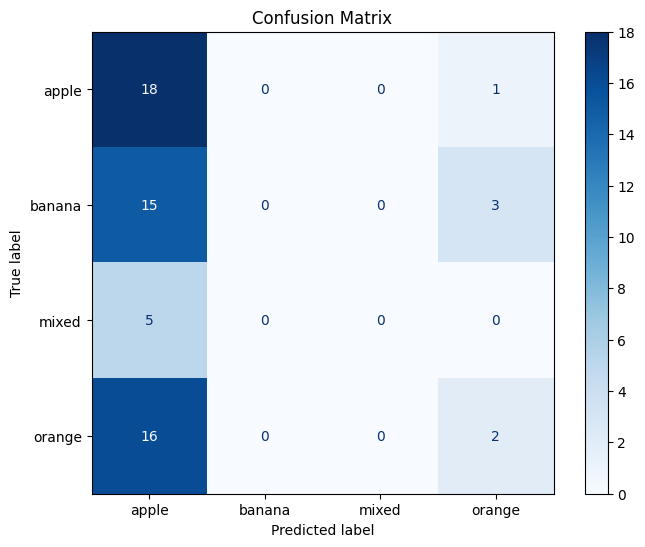

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred = vit_model.predict(test_generator)
y_true = test_generator.classes


y_pred_labels = np.argmax(y_pred, axis=1)


cm = confusion_matrix(y_true, y_pred_labels, labels=np.arange(4)) 


labels = ['apple', 'banana', 'mixed', 'orange']  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [53]:
from sklearn.metrics import classification_report


report = classification_report(y_true, y_pred_labels, target_names=labels, zero_division=0)


print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       apple       0.33      0.95      0.49        19
      banana       0.00      0.00      0.00        18
       mixed       0.00      0.00      0.00         5
      orange       0.33      0.11      0.17        18

    accuracy                           0.33        60
   macro avg       0.17      0.26      0.16        60
weighted avg       0.21      0.33      0.21        60

